## Demonstration notebook for TreeLS
This notebook will outline the tree species classification process, from raw point clouds of individual trees through predicting with a trained model. <br/>

For this notebook, the following file/folder structure is used: <br/>

<pre>
|-- LICENSE 
|-- README.md 
|-- TreeLS.yml 
| 
|-- data 
|   |-- treesXYZ 
|       |-- tree_id1.txt --> .txt files with containing point cloud data 
|                             i.e x1 y1 z1
|                                 x2 y2 z2
|       |-- tree_id2.txt      
|       |-- ... 
|
|   |-- meta
|       |-- tree-meta.csv --> metadata file describing species for each sample in treesXYZ
|                             it should have two columns 'id' and 'sp' containing identifiers and species labels
|                             with the id matching the filename for the corresponding pointcloud (w/o file extension)
|
|                             e.g. 
|                             id	    sp
|                             tree_id1	QUEFAG
|                             ...
| 
|-- utils 
|   |-- __init__.py 
|   |-- dataset.py 
|   |-- utils.py 
|   |-- train.py 
|   |-- test.py 
| 
|-- sh 
|   |-- dl-simpleview.sh 
</pre>

Before running anything, the code for the core model needs to be pulled:

In [1]:
# #Clone Simpleview repo
# !git clone https://github.com/IsaacCorley/simpleview-pytorch

# !cd simpleview-pytorch

# #Remove git stuff + non-classification bits
# !rm -r assets
# !rm -f LICENSE
# !rm -f README.md
# !rm -f .gitignore

# !cd ..

# !mv simpleview-pytorch/simpleview_pytorch simpleview_pytorch
# !rm -r -f simpleview-pytorch

In [2]:
#Imports
import shutil, os
import numpy as np
import utils
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/home/matt/miniconda3/envs/tlspecies/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll start by taking a look at some of the data:

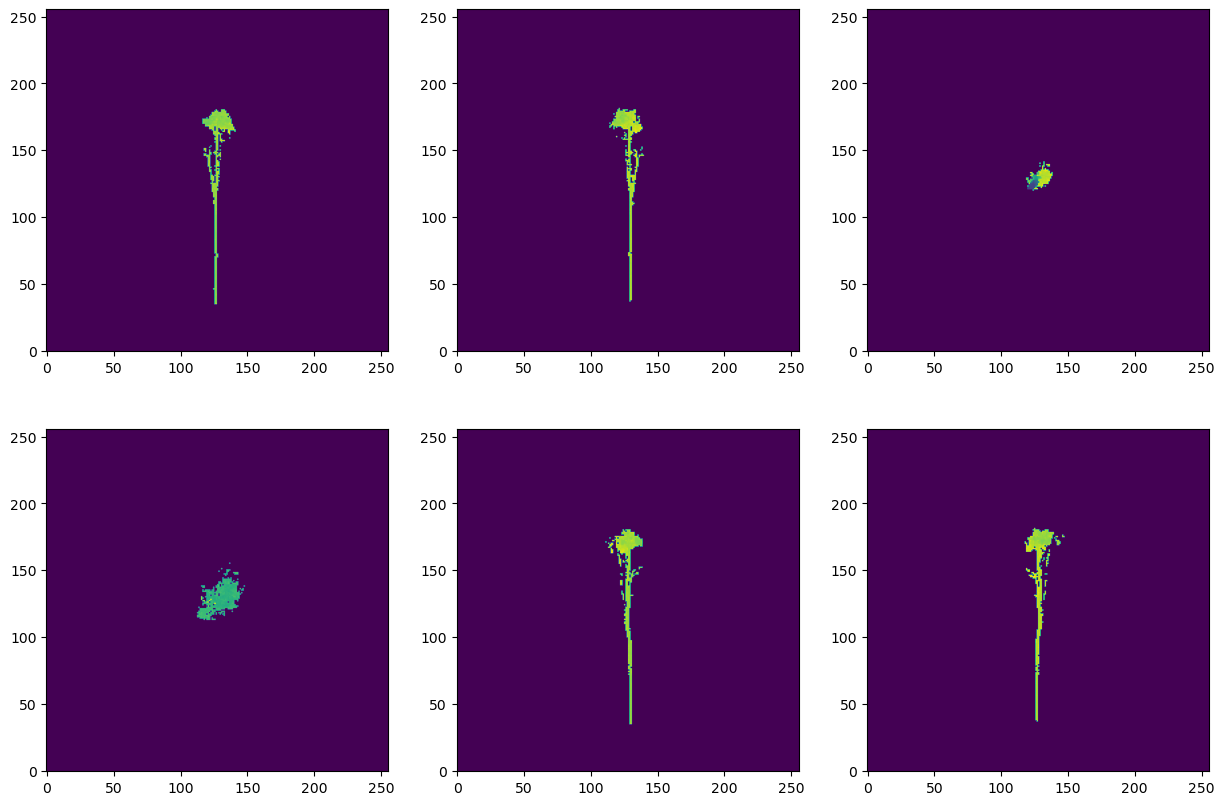

In [3]:
cloud = utils.pc_from_txt("data/Tr3D_species/treesXYZ/100.txt") #Load from file
cloud = utils.center_and_scale(cloud) #Center and scale into [-1,1]^3

sample_images = utils.get_depth_images_from_cloud(cloud, image_dim=256) #Generate the projections
fig, ax = utils.plot_depth_images(sample_images, nrows=2)

Our data isn't split into train/validation/test sets, so we'll do it randomly here. Since the dataset we used in the paper was quite large, the class balance turns out about the same without the need for stratified sampling. If you want to use specific samples in the train/test sets, it's fine to separate the folders by hand - just skip the two cells below.

In [ ]:
filenames = os.listdir('data/treesXYZ/')
seed = 0
train_filenames, rest_filenames = train_test_split(filenames, train_size=0.7, shuffle=True, random_state=seed) #0.7/0.3 for train data/rest of data
val_filenames, test_filenames = train_test_split(rest_filenames, train_size=0.5, shuffle=True, random_state=seed) #Split rest of data 0.5/0.5 for 0.15/0.15 val/test overall

We'll copy the train/test/val splits into separate folders. You could delete the orginial folder to save space. This cell can take a while, depending on how much data there is.

In [ ]:
#Train folder
train_folder = 'data/train'
os.mkdir(train_folder)
for f in train_filenames: 
    shutil.copy(f'data/treesXYZ/{f}', train_folder)

#Val folder
val_folder = 'data/val'
os.mkdir(val_folder)
for f in val_filenames: 
    shutil.copy(f'data/treesXYZ/{f}', val_folder)

#Test folder
test_folder = 'data/test'
os.mkdir(test_folder)
for f in test_filenames: 
    shutil.copy(f'data/treesXYZ/{f}', test_folder)

Pytorch datasets can now be built from these folders, along with the original metadata file. This does mean that the data gets duplicated quite a lot of times. Please remove any copies that you don't need; they are left in place here to aid script debugging. 

The random transforms to be used (Rotation, Translation, Scaling) should be set per-dataset. They are OFF by default, and will also be forced off for the validation/test sets during inference. All three are enabled for the train set in the cell below. Various other parameters (Augmentation hyperparameters, camera parameters) can also be adjusted similarly. They are equal to the values described in the paper by default.

If you don't want any transforms, you should set the value of .transforms to ['none'] (i.e. in a list)

In [ ]:
from matplotlib import transforms


metadata_file = 'data/meta/tree-meta.csv'

train_dataset = utils.TreeSpeciesPointDataset(data_dir='data/train/', metadata_file=metadata_file)
train_dataset.set_params(transforms = ['rotation','translation','scaling']) #Other parameters can be changes - for example ...set_params(image_dim=128) .set_params(max_rotation=0.5) etc.
torch.save(train_dataset, "data/trees_train.pt")

val_dataset = utils.TreeSpeciesPointDataset(data_dir='data/val/', metadata_file=metadata_file)
torch.save(val_dataset, "data/trees_val.pt")

test_dataset = utils.TreeSpeciesPointDataset(data_dir='data/test/', metadata_file=metadata_file)
torch.save(test_dataset, "data/trees_test.pt")

Some quick sanity checks:

In [ ]:
utils.plot_depth_images(test_dataset.__getitem__(54)['depth_images'])

In [ ]:
test_dataset.meta_frame.head()

In [ ]:
test_dataset.labels[:5]

First there are a few training parameters to specify - note that you should specify the species in your dataset you wish to include here. For example, 5 species are considered from our dataset. A single juniper tree and unidentified species are not included.:

In [ ]:
params = {
    "batch_size":128,
    "shuffle_dataset":True,
    "random_seed":0,
    "learning_rate":[0.001,50,0.5],  #[init, step_size, gamma] for scheduler
    "momentum":0.9, #Only used for sgd, ignroed for adam
    "epochs":200,
    "loss_fn":"smooth-loss",
    "optimizer":"adam",
    "train_sampler":"balanced",

    "model":"SimpleView",

    "species":["QUEFAG", "PINNIG", "QUEILE", "PINSYL", "PINPIN"],
}

Now we can train a model using the train/val/test datasets. If you try to rerun this cell without restarting the kernel, it might crash. If you use VS Code, it might hide some of the output.:

In [ ]:
utils.train(train_data="data/trees_train.pt",
            val_data="data/trees_val.pt",
            test_data="data/trees_test.pt",
            model_dir='models',
            params=params)

Now we can see the model predictions on the test dataset, and plot the confusion matrix:

In [ ]:
_, labels, predictions, species = utils.predict_from_dirs('data/trees_test.pt', 'models/2022-08-15 11:30:23.374472_best', params={'species':["QUEFAG", "PINNIG", "QUEILE", "PINSYL", "PINPIN"], 'num_views':6}) #Predictions for whole test dataset
print(species) #Might be in a different order to the one specified in the config

fig, ax = plt.subplots(1,1, figsize=(24,24))
tickFont = 28
axFont = 48
annotFont = 36

cm = confusion_matrix(labels.cpu(), predictions.cpu(), normalize='true')
hm = sns.heatmap(cm, annot=True, ax=ax, cbar=False, annot_kws={"fontsize":annotFont})
hm.set_xticklabels(species, fontsize=tickFont, style = 'italic')
ax.set_yticklabels(species, fontsize=tickFont)
hm.set_ylabel('True Labels', fontsize=axFont+2)
hm.set_xlabel('Predictions', fontsize=axFont)